In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import dateutil

## Goal of the project

Predict employee retention and understand its main drivers. Specifically, you should:

Assume, for each company, that the headcount starts from zero on 2011/01/23. Estimate
employee headcount, for each company, on each day, from 2011/01/24 to 2015/12/13.
That is, if by 2012/03/02 2000 people have joined company 1 and 1000 of them have
already quit, then company headcount on 2012/03/02 for company 1 would be 1000.
You should create a table with 3 columns: day, employee_headcount, company_id.

What are the main factors that drive employee churn? Do they make sense? Explain your
findings.

If you could add to this data set just one variable that could help explain employee churn,
what would that be?


In [99]:
data = pd.read_csv('employee_retention_data.csv')
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [100]:
# Remove rows with wrong values for seniority
# the drop function supports inplace replacement, i.e., your solution alters the original dataframe
# axis=0 is the default
wrong_sen_mask = data['seniority'] > 50
data.drop(data[wrong_sen_mask].index,axis = 0,inplace=True)

## First step

Create tables with company id and date (within a specified date range). For each date, count the number of employees for each company.

In [101]:
np.unique(data.company_id.values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

Convert all the date to Python datetime format. All the NaN's are converted to NaT's.

In [102]:
data['join_date'] = pd.to_datetime(data['join_date'])
data['quit_date'] = pd.to_datetime(data['quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


Create a date range.

In [103]:
# the data type is called "datetime64"
dateRange = np.arange('2011-01-23', '2015-12-13', dtype='datetime64[D]')
dateRange[:20]

array(['2011-01-23', '2011-01-24', '2011-01-25', '2011-01-26',
       '2011-01-27', '2011-01-28', '2011-01-29', '2011-01-30',
       '2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03',
       '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07',
       '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11'], dtype='datetime64[D]')

In [104]:
# Create a temp table with all dates within the dateRange
# Create a column named "date", filled the np array dateRange in this column
retention_data = pd.DataFrame({'date': dateRange})
retention_data.head(10)

,date
0,2011-01-23
1,2011-01-24
2,2011-01-25
3,2011-01-26
4,2011-01-27
5,2011-01-28
6,2011-01-29
7,2011-01-30
8,2011-01-31
9,2011-02-01


In [105]:
def count_employees(company, date):
    # create a temp dataframe for each company
    company_df = data[data.company_id == company]
    # for a given date "A", the join_date has to be earlier than "A", and the quit_date has to be either later than "A" or shows NaN
    condition = ((company_df.join_date <= date) & ((company_df.quit_date >= date) | (pd.isnull(company_df.quit_date))))
    # len returns the row count given certain conditions
    return len(company_df[condition])

In [106]:
# apply means apply functions in the dataframe, axis=1 means apply function to each row
# lambda x means the function is count_employees
# when I loop over each company, an new column rentention_data[company] is generated
# x refers to the original retention_data dataframe which contains index and date
for company in range(1, 13):
    retention_data[company] = retention_data.apply(lambda x: count_employees(company, x.date), axis=1)

In [107]:
retention_data.head()

,date,1,2,3,4,5,6,7,8,9,10,11,12
0,2011-01-23,0,0,0,0,0,0,0,0,0,0,0,0
1,2011-01-24,25,17,9,12,5,3,1,6,3,0,0,0
2,2011-01-25,27,19,10,12,5,3,1,6,3,0,0,0
3,2011-01-26,29,19,12,13,6,3,1,6,3,0,0,0
4,2011-01-27,29,19,12,13,6,3,1,6,3,0,0,0


## Add new features
Add a column of work duration

In [108]:
data['duration'] = data['quit_date'] - data['join_date']
# the result (new "duration column") has the unit of days, now we need to get rid of the unit
data['duration'] = data['duration'].apply(lambda x: x.days)

In [109]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


## Exploratory data analysis


Populating the interactive namespace from numpy and matplotlib


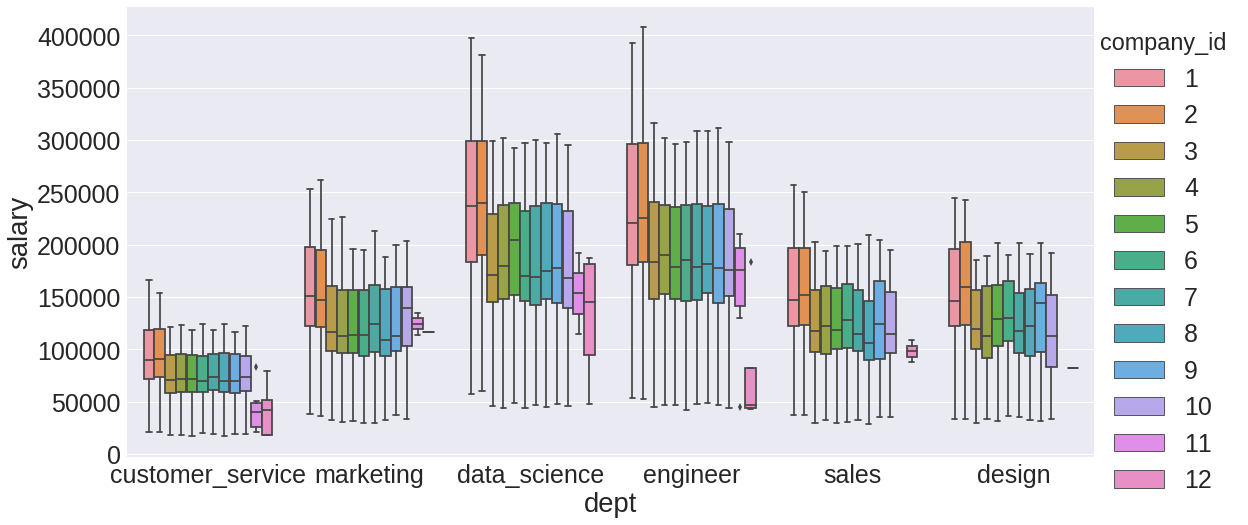

In [110]:
%pylab inline
# factorplot draws categorical plot
# sns.set font_scale controls the font size
sns.set(font_scale=2.5)
sns.factorplot(x='dept', y='salary', hue='company_id', data=data, kind='box', size=8, aspect=2)

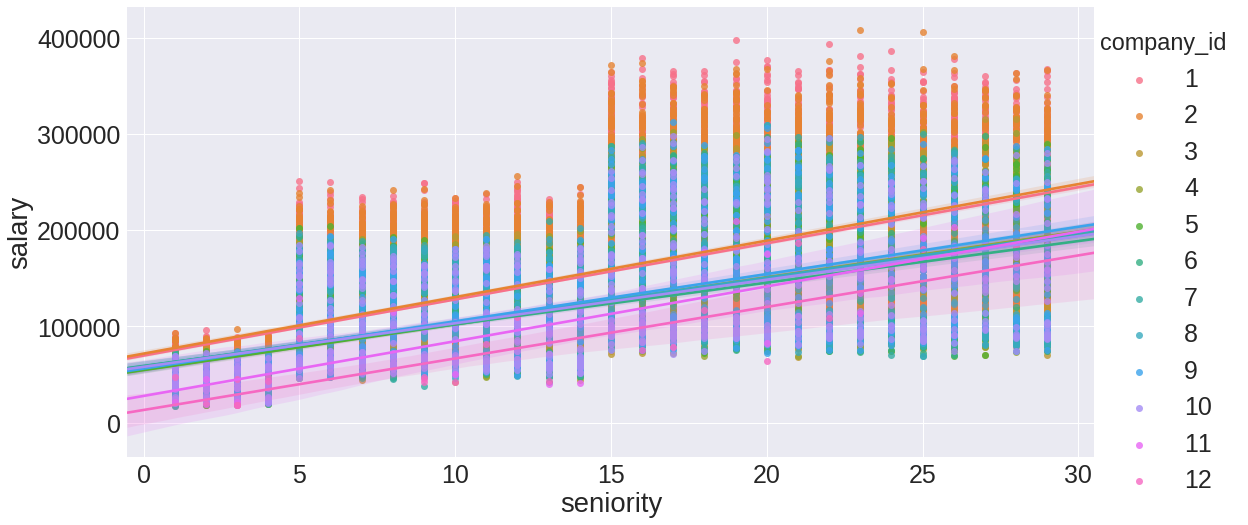

In [111]:
sns.lmplot(x='seniority', y='salary', hue='company_id', data=data, size=8, aspect=2)

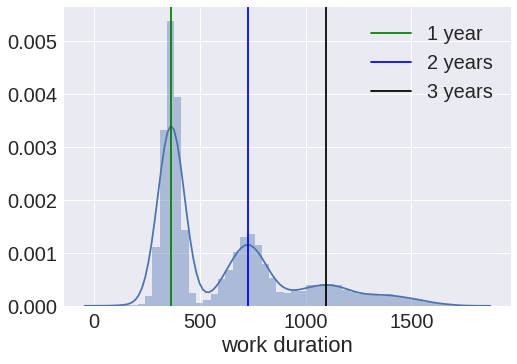

In [112]:
sns.set(font_scale=2)
ax=sns.distplot(data.duration.dropna(), axlabel='work duration')
plt.axvline(365, color='g', label='1 year')
plt.axvline(730, color='b', label='2 years')
plt.axvline(1095, color='k', label='3 years')
plt.legend()

Encoding the department column

In [120]:
data1=data
data1.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


In [121]:
data1['quit']=1
data1.loc[(data1['duration'].isnull()), 'quit']=0
data1.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,duration,quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,1
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,1


In [122]:
data1.drop(labels=['employee_id', 'join_date', 'quit_date', 'duration'], axis=1, inplace=True)
data1.head()

,company_id,dept,seniority,salary,quit
0,7,customer_service,28,89000.0,1
1,7,marketing,20,183000.0,1
2,4,marketing,14,101000.0,0
3,7,customer_service,20,115000.0,1
4,2,data_science,23,276000.0,1


In [123]:
data1=pd.get_dummies(columns=['dept'], data=data)
data1.head()

,company_id,seniority,salary,quit,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,7,28,89000.0,1,1,0,0,0,0,0
1,7,20,183000.0,1,0,0,0,0,1,0
2,4,14,101000.0,0,0,0,0,0,1,0
3,7,20,115000.0,1,1,0,0,0,0,0
4,2,23,276000.0,1,0,1,0,0,0,0


In [124]:
y = data1['quit']
y.head()

0    1
1    1
2    0
3    1
4    1
Name: quit, dtype: int64

In [125]:
# select all columns except 'quit'
X = data1.loc[:, data1.columns != 'quit']
X.head()

,company_id,seniority,salary,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,7,28,89000.0,1,0,0,0,0,0
1,7,20,183000.0,0,0,0,0,1,0
2,4,14,101000.0,0,0,0,0,1,0
3,7,20,115000.0,1,0,0,0,0,0
4,2,23,276000.0,0,1,0,0,0,0


In [126]:
#data1['quit_date']=data1['quit_date'].fillna("2015-12-13")
#data1.dropna(axis=0, inplace=True)

In [129]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5 )

# X_train=preprocessing.MinMaxScaler().fit_transform(data_train)
# X_test=preprocessing.MinMaxScaler().fit_transform(data_test)
#T=preprocessing.MaxAbsScaler().fit_transform(data_train)
#T=data_train
#T=preprocessing.Normalizer().fit_transform(data_train)
# Random forest

random_forest = RandomForestClassifier(n_estimators=150 ,min_samples_leaf=5, max_depth=3, max_features=3)
random_forest.fit(X_train, y_train)
y_pred_RF = random_forest.predict(X_test)
score_train_RF = random_forest.score(X_train, y_train)*100
score_train_RF

56.772700983227296

In [130]:
score_test_RF = random_forest.score(X_test, y_test)*100
score_test_RF

55.290148448043183

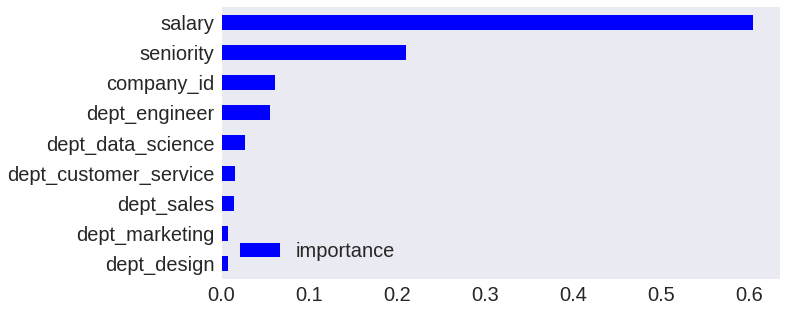

In [136]:
# predict feature importance
names = X_train.columns
ratios = random_forest.feature_importances_

feature_important = pd.DataFrame(index=names, data=ratios, columns=['importance'])
feature_important = feature_important.sort_values(by=['importance'], ascending=True)
feature_important.plot(kind='barh', stacked=True, color=['blue'], grid=False, figsize=(10, 5))

In [138]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(min_samples_leaf=10,  max_features=8)
decision_tree.fit(X_train, y_train)
y_pred_DT = decision_tree.predict(X_test)
score_train_DT = round(decision_tree.score(X_train, y_train) * 100, 2)
print(score_train_DT)

66.82


In [139]:
score_test_DT = round(decision_tree.score(X_test, y_test) * 100, 2)
print(score_test_DT)

51.48


In [142]:
# 3-fold cross validation to check for overfitting
# "cross_val_score" splits the data repeatedly into a traininng and a testing set
#      trains the estimator using the training set and computes the scores based 
#      on the testing set for each iteration of cross-validation
from sklearn.model_selection import cross_val_score
cval_score = cross_val_score(decision_tree, X, y, cv=3)
cval_score

array([ 0.50740831,  0.512752  ,  0.51202624])

In [144]:
mean_cval=cval_score.mean()*100
std_cval = cval_score.std()*100
mean_cval
#std_cval

51.072884999101831

In [145]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred_RF))

             precision    recall  f1-score   support

          0       0.54      0.17      0.26      3398
          1       0.56      0.88      0.68      4012

avg / total       0.55      0.55      0.49      7410



## results

Both decision trees and random forests algorithms were applied. However, they are not predictive. To increase the prediction accuracy, one can choose to include more information, such as reason of quiting and data from other years, more companies.